# Tessellation-based blocks
## Ideal case with ideal data

Assume following situation: We have a layer of buildings for selected city, a street network represented by centrelines, we have generated morphological tessellation, but now we would like to do some work on block scale. We have two options - generate blocks based on street network (each closed loop is a block) or use morphological tessellation and join those cells, which are expected to be part of one block. In that sense, you will get tessellation-based blocks which are following the same logic as the rest of your data and are hence fully compatible. With `momepy` you can do that using `momepy.Blocks`. 

In [1]:
import momepy
import geopandas as gpd
import matplotlib.pyplot as plt

For illustration, we can use `bubenec` dataset embedded in `momepy`.

In [2]:
path = momepy.datasets.get_path('bubenec')
buildings = gpd.read_file(path, layer='buildings')
streets = gpd.read_file(path, layer='streets')
tessellation = gpd.read_file(path, layer='tessellation')

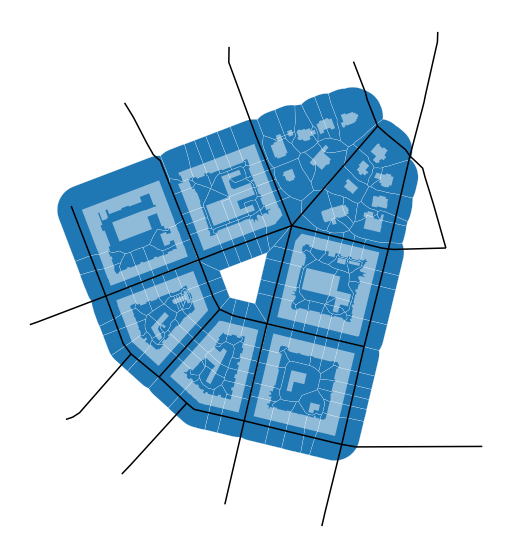

In [3]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax, edgecolor='white', linewidth=0.2)
buildings.plot(ax=ax, color='white', alpha=.5)
streets.plot(ax=ax, color='black')
ax.set_axis_off()
plt.show()

This example is useful for illustration why pure network-based blocks are not ideal.
1. In the centre of the area would be the block, while it is clear that there is only open space.
2. Blocks on the edges of the area would be complicated, as streets do not fully enclose them.

None of it is an issue for tessellation-based blocks. `momepy.Blocks` requires buildings, tessellation, streets and IDs. We have it all, so we can give it a try.

In [4]:
blocks = momepy.Blocks(
    tessellation, streets, buildings, id_name='bID', unique_id='uID')

 25%|██▌       | 36/144 [00:00<00:00, 359.36it/s]

Buffering streets...
Generating spatial index...
Difference...


100%|██████████| 254/254 [00:00<00:00, 293243.38it/s]


Defining adjacency...
Defining street-based blocks...
Defining block ID...
Generating centroids...
Spatial join...
Attribute join (tesselation)...
Generating blocks...
Multipart to singlepart...
Attribute join (buildings)...
Attribute join (tesselation)...


GeoDataFrame containing blocks can be accessed using `blocks`. Moreover, block ID for buildings and tessellation can be accessed using `buildings_id` and `tessellation_id`.

In [5]:
blocks_gdf = blocks.blocks
buildings['bID'] = blocks.buildings_id
tessellation['bID'] = blocks.tessellation_id

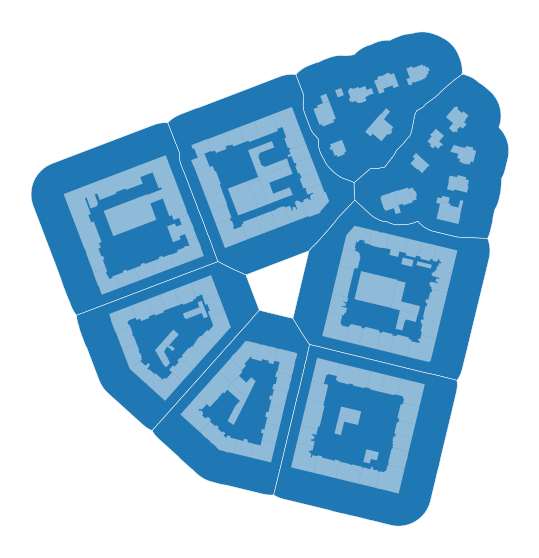

In [6]:
f, ax = plt.subplots(figsize=(10, 10))
blocks_gdf.plot(ax=ax, edgecolor='white', linewidth=0.5)
buildings.plot(ax=ax, color='white', alpha=.5)
ax.set_axis_off()
plt.show()

## Fixing the street network

The example above shows how it works in the ideal case - streets are attached, there are no gaps. However, that is often not true. For that reason, `momepy` includes `momepy.snap_street_network_edge` utility which is supposed to fix the issue. It can do two types of network adaptation:

1. **Snap network onto the network where false dead-end is present.** It will extend the last segment by set distance and snap it onto the first reached segment.
2. **Snap network onto the edge of tessellation.** As we need to be able to define blocks until the very edge of tessellation, in some cases, it is necessary to extend the segment and snap it to the edge of the tessellated area.

Let's adapt our ideal street network and break it to illustrate the issue.

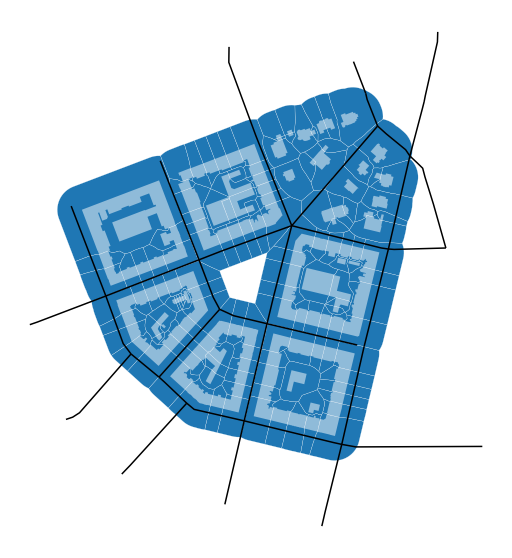

In [7]:
import shapely
geom = streets.iloc[33].geometry
splitted = shapely.ops.split(geom, shapely.geometry.Point(geom.coords[5]))
streets.loc[33, 'geometry'] = splitted[1]
geom = streets.iloc[19].geometry
splitted = shapely.ops.split(geom, geom.representative_point())
streets.loc[19, 'geometry'] = splitted[0]

f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax, edgecolor='white', linewidth=0.2)
buildings.plot(ax=ax, color='white', alpha=.5)
streets.plot(ax=ax, color='black')
ax.set_axis_off()
plt.show()

In this example, one of the lines on the right side is not snapped onto the network and other on the top-left leaves the gap between the edge of the tessellation. Let's see what would be the result of blocks without any adaptation of this network.

In [8]:
buildings.drop(['bID'], axis=1, inplace=True)
tessellation.drop(['bID'], axis=1, inplace=True)

In [9]:
blocks = momepy.Blocks(tessellation, streets, buildings,
                       id_name='bID', unique_id='uID').blocks

100%|██████████| 144/144 [00:00<00:00, 723.85it/s]

Buffering streets...
Generating spatial index...
Difference...
Defining adjacency...



100%|██████████| 252/252 [00:00<00:00, 312989.22it/s]


Defining street-based blocks...
Defining block ID...
Generating centroids...
Spatial join...
Attribute join (tesselation)...
Generating blocks...
Multipart to singlepart...
Attribute join (buildings)...
Attribute join (tesselation)...


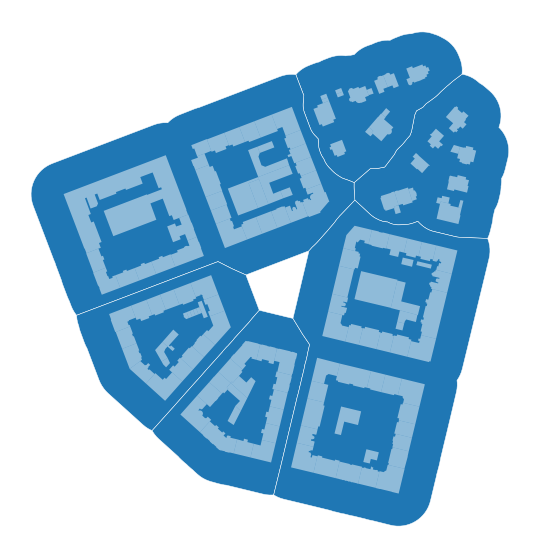

In [10]:
f, ax = plt.subplots(figsize=(10, 10))
blocks.plot(ax=ax, edgecolor='white', linewidth=0.5)
buildings.plot(ax=ax, color='white', alpha=.5)
ax.set_axis_off()
plt.show()

We can see that blocks are merged. To avoid this effect, we will first use `momepy.snap_street_network_edge` and then generate blocks.

In [11]:
snapped = momepy.snap_street_network_edge(streets, buildings, tolerance_street=15,
                                          tessellation=tessellation, 
                                          tolerance_edge=40)

Snapping: 100%|██████████| 35/35 [00:00<00:00, 270.63it/s]

Building spatial index for network...
Building spatial index for buildings...
Dissolving tesselation...


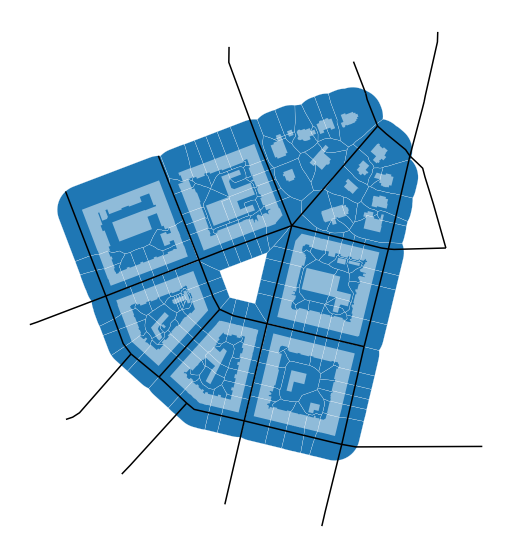

In [12]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax, edgecolor='white', linewidth=0.2)
buildings.plot(ax=ax, color='white', alpha=.5)
snapped.plot(ax=ax, color='black')
ax.set_axis_off()
plt.show()

What should be snapped is now snapped. We might have noticed that we had to give buildings to the `momepy.snap_street_network_edge`. That is to avoid extending segments through buildings.

With a fixed network, we can then generate correct blocks.

In [13]:
blocks = momepy.Blocks(
    tessellation, snapped, buildings, id_name='bID', unique_id='uID').blocks

 98%|█████████▊| 141/144 [00:00<00:00, 647.70it/s]

Buffering streets...
Generating spatial index...
Difference...


100%|██████████| 255/255 [00:00<00:00, 504979.94it/s]


Defining adjacency...
Defining street-based blocks...
Defining block ID...
Generating centroids...
Spatial join...
Attribute join (tesselation)...
Generating blocks...
Multipart to singlepart...
Attribute join (buildings)...
Attribute join (tesselation)...


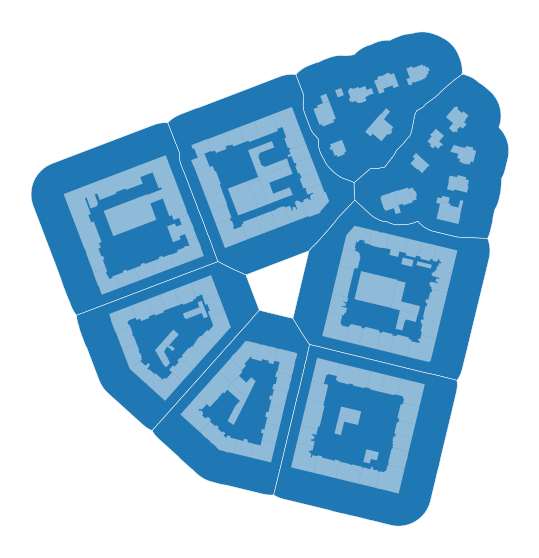

In [14]:
f, ax = plt.subplots(figsize=(10, 10))
blocks.plot(ax=ax, edgecolor='white', linewidth=0.5)
buildings.plot(ax=ax, color='white', alpha=.5)
ax.set_axis_off()
plt.show()